In [120]:
import pandas as pd
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [121]:
print(tf.__version__)

2.16.1


#Veri setinin yüklenmesi ve türlerin listelenmesi

In [122]:
data_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(data_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

#Görüntü dosya yolları ve etiketleme

In [123]:
labels = []
paths = []
for dir_name, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name.split():
            labels.append(os.path.split(dir_name)[-1])
            paths.append(os.path.join(dir_name, filename))


#Veriyi tanıma ve ön işleme

In [124]:
 df = pd.DataFrame({'path': paths, 'label': labels})
print(df.info())
print(df.head())
print("Veri çerçevesinin boyutu:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
Veri çerçevesinin boyutu: (9000, 2)


#Sınıfları görselleştirme

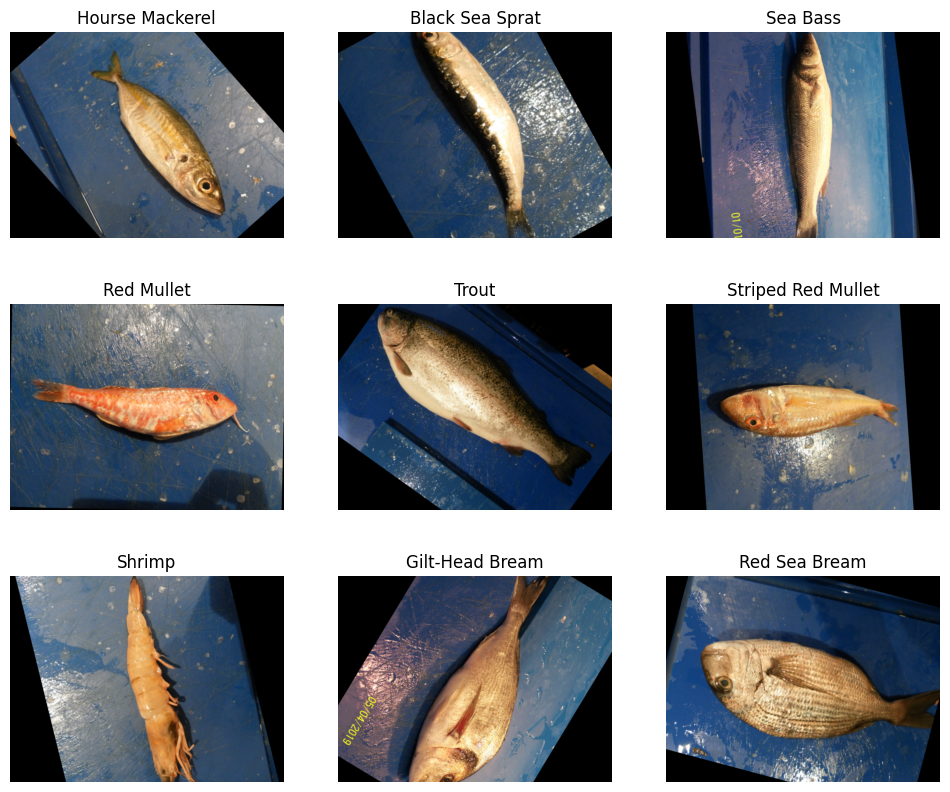

In [125]:
plt.figure(figsize=(12, 10))
for idx, label in enumerate(df['label'].unique()):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(plt.imread(df[df['label'] == label].iloc[0, 0]))
    plt.title(label)
    plt.axis('off')
plt.show()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


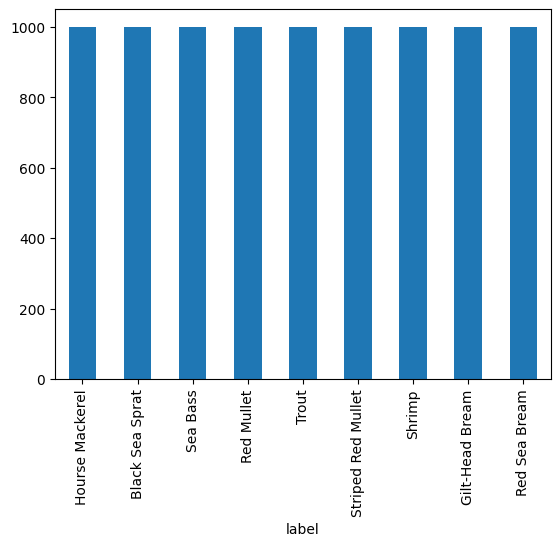

In [126]:
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

In [127]:
# Eğitim ve test verilerini %80 - %20 oranında ayırma
X_train, X_test, y_train, y_test = train_test_split(
    df['path'], df['label'], test_size=0.2, random_state=42
)

print(f"Eğitim Verisi: {len(X_train)}, Test Verisi: {len(X_test)}")

Eğitim Verisi: 7200, Test Verisi: 1800


In [128]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
IMG_SIZE = (64, 64)  # Görsel boyutu

# Batch halinde görselleri işleyen fonksiyon
def preprocess_images_in_batches(image_paths, batch_size=100):
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]  
        images = []
        for path in batch_paths:
            img = load_img(path, target_size=IMG_SIZE)  # Görseli yükleme ve yeniden boyutlandırma
            img_array = img_to_array(img) / 255.0  # Normalizasyon
            images.append(img_array)  # Görseli listeye ekleme
        yield np.array(images)  # Batch'teki tüm görselleri numpy dizisi olarak döndür

for X_batch in preprocess_images_in_batches(X_train, batch_size=100):
   
    print(f'Processed batch of size {X_batch.shape}')

# Test verisini batch'lerle işleme
for X_batch_test in preprocess_images_in_batches(X_test, batch_size=100):
    # Her batch'te işlenen test verilerinde işlem yapabilirsiniz.
    print(f'Processed test batch of size {X_batch_test.shape}')

Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch of size (100, 64, 64, 3)
Processed batch 

In [140]:
#One-hot encoding and Train set 
image_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,            
    x_col='path',              
    y_col='label',             
    target_size=image_size,    
    batch_size=32,             
    class_mode='categorical',  
    subset='training'          
)

#Validaiton
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'        
)

#Test set

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False   )     # no shuffle in test set

Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


#ANN modelleme 

In [141]:
model = Sequential([
    Flatten(input_shape=(224, 224, 3)),  # Görseli tek boyutlu hale getir
    Dense(512, activation='relu'),       # İlk dense katman
    Dense(256, activation='relu'),       # İkinci dense katman
    Dense(128, activation='relu'),       # Üçüncü dense katman
    Dense(len(train_data['label'].unique()), activation='softmax')  # Çıkış katmanı
])

# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini görüntüleme
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_16 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,236,233 (294.63 MB)

 Trainable params: 77,236,233 (294.63 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Modeli derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [143]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    restore_best_weights=True,  
    verbose=1           
)

In [144]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 73s 385ms/step - accuracy: 0.2361 - loss: 19.3946 - val_accuracy: 0.4965 - val_loss: 1.5764
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 381ms/step - accuracy: 0.5923 - loss: 1.2593 - val_accuracy: 0.6278 - val_loss: 1.0888
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 377ms/step - accuracy: 0.7232 - loss: 0.7844 - val_accuracy: 0.6354 - val_loss: 1.0483
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 382ms/step - accuracy: 0.7411 - loss: 0.7320 - val_accuracy: 0.7875 - val_loss: 0.6483
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 383ms/step - accuracy: 0.8248 - loss: 0.5042 - val_accuracy: 0.8083 - val_loss: 0.5356
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 384ms/step - accuracy: 0.8856 - loss: 0.3437 - val_accuracy: 0.7160 - val_loss: 0.8656
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 71s 385ms/step - accuracy: 0.7442 - loss: 0.8069 - val_accuracy: 0.8250 - val_loss: 0.5397
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 72s 386ms/step - accuracy: 0.8690 - loss: 

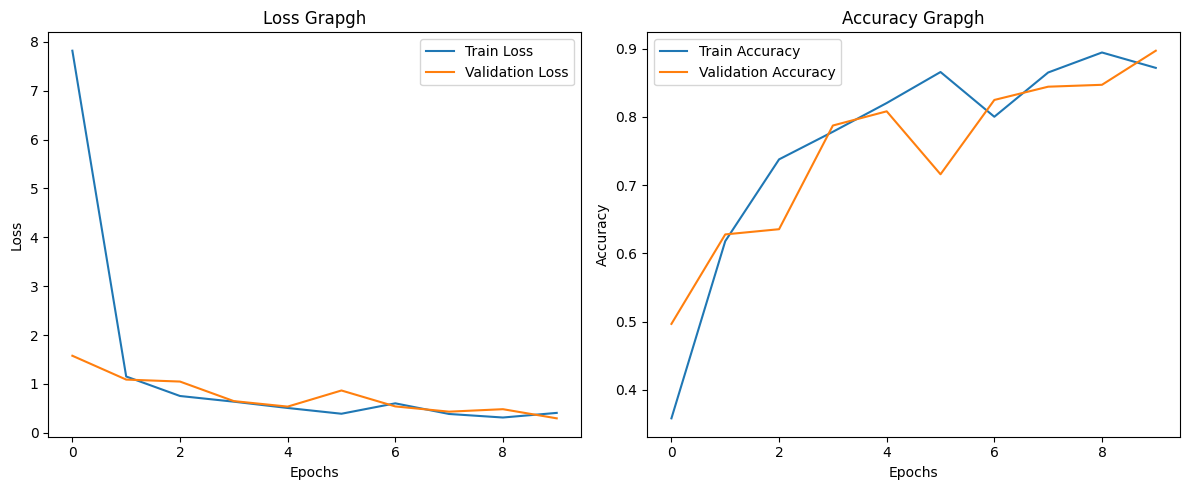

In [145]:
#Results figure 
plt.figure(figsize=(12, 5))

# Loss grap
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step
                    precision    recall  f1-score   support

   Hourse Mackerel       0.91      0.95      0.93       211
   Black Sea Sprat       0.89      0.79      0.84       204
          Sea Bass       0.93      0.92      0.93       195
        Red Mullet       0.96      0.90      0.93       191
             Trout       0.90      0.96      0.93       201
Striped Red Mullet       0.83      0.89      0.86       179
            Shrimp       0.90      0.91      0.91       209
   Gilt-Head Bream       0.83      0.93      0.88       207
     Red Sea Bream       0.90      0.78      0.84       203

          accuracy                           0.89      1800
         macro avg       0.89      0.89      0.89      1800
      weighted avg       0.89      0.89      0.89      1800



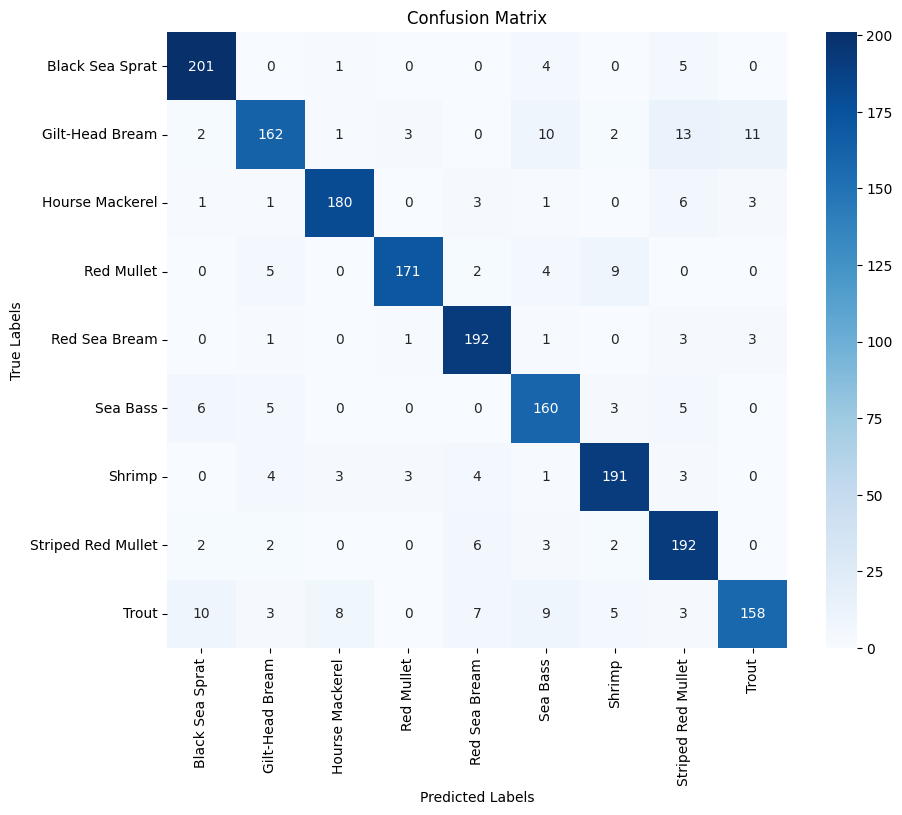

Test Loss: 0.33339565992355347
Test Accuracy: 0.8927778005599976


In [146]:
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)

true_labels=test_generator.classes
print(classification_report(test_generator.classes, test_pred_classes, target_names=classes))
cm = confusion_matrix(true_labels, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

In [ ]:
#Hipermetre optimizasyonu

In [148]:
from sklearn.metrics import classification_report, accuracy_score, f1_score,precision_score, confusion_matrix, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
model = Sequential()

model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))

model.add(Dense(len(train_data['label'].unique()), activation='softmax'))  #output layer


opt= Adam(learning_rate=0.00001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model summary
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,204,489 (294.51 MB)

 Trainable params: 77,204,489 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=3,         
    restore_best_weights=True,  
    verbose=1           
)

In [151]:
history = model.fit(train_generator, 
                    epochs=10,
                    batch_size = 32,
                    validation_data=test_generator,
                    callbacks=[early_stopping])

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 429ms/step - accuracy: 0.2755 - loss: 1.9659 - val_accuracy: 0.5150 - val_loss: 1.4213
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 78s 420ms/step - accuracy: 0.5168 - loss: 1.3832 - val_accuracy: 0.6289 - val_loss: 1.0935
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 78s 419ms/step - accuracy: 0.5955 - loss: 1.1589 - val_accuracy: 0.6933 - val_loss: 0.9442
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 417ms/step - accuracy: 0.6732 - loss: 0.9817 - val_accuracy: 0.7539 - val_loss: 0.8139
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 77s 413ms/step - accuracy: 0.7130 - loss: 0.8722 - val_accuracy: 0.7817 - val_loss: 0.7313
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 75s 405ms/step - accuracy: 0.7547 - loss: 0.7653 - val_accuracy: 0.7844 - val_loss: 0.7002
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 75s 406ms/step - accuracy: 0.7711 - loss: 0.6998 - val_accuracy: 0.8256 - val_loss: 0.6239
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 75s 404ms/step - accuracy: 0.7877 - loss: 0

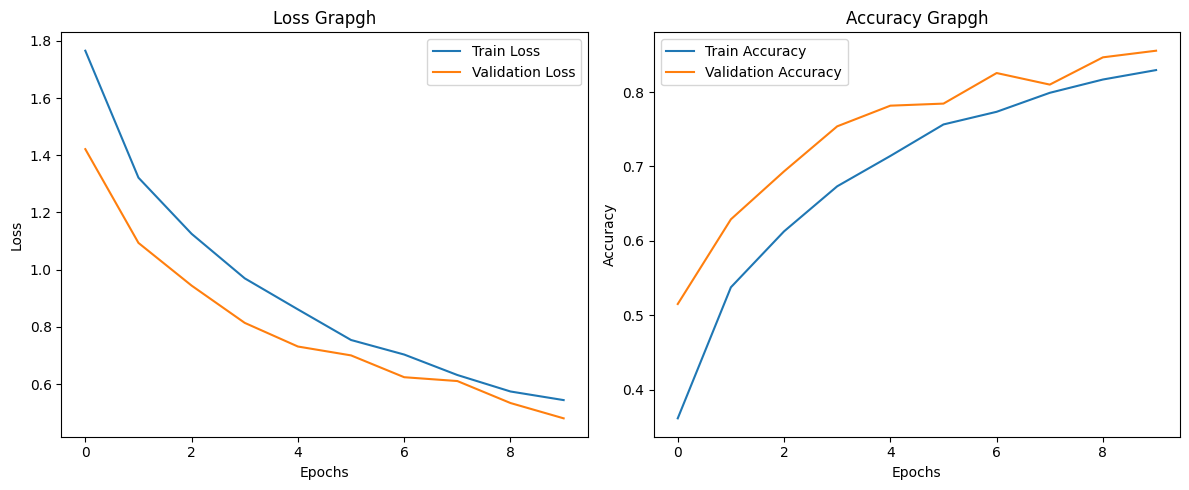

In [152]:
#Results figure 
plt.figure(figsize=(12, 5))

# Loss grap
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grapgh')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 333ms/step
                    precision    recall  f1-score   support

   Hourse Mackerel       0.86      0.90      0.88       211
   Black Sea Sprat       0.91      0.81      0.86       204
          Sea Bass       0.82      0.94      0.88       195
        Red Mullet       0.83      0.94      0.88       191
             Trout       0.97      0.84      0.90       201
Striped Red Mullet       0.85      0.85      0.85       179
            Shrimp       0.81      0.93      0.87       209
   Gilt-Head Bream       0.89      0.73      0.80       207
     Red Sea Bream       0.79      0.76      0.78       203

          accuracy                           0.86      1800
         macro avg       0.86      0.86      0.85      1800
      weighted avg       0.86      0.86      0.85      1800



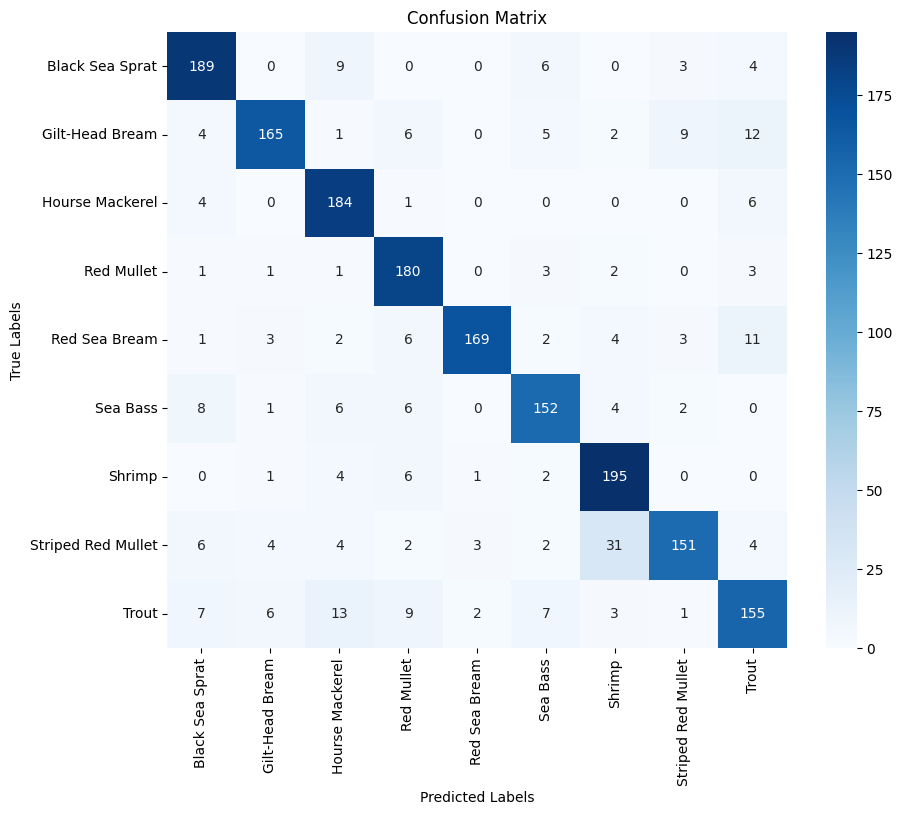

In [153]:
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
true_labels=test_generator.classes
print(classification_report(test_generator.classes, test_pred_classes, target_names=classes))
cm = confusion_matrix(true_labels, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [154]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Test Loss: 0.48018255829811096
Test Accuracy: 0.855555534362793


57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 327ms/step


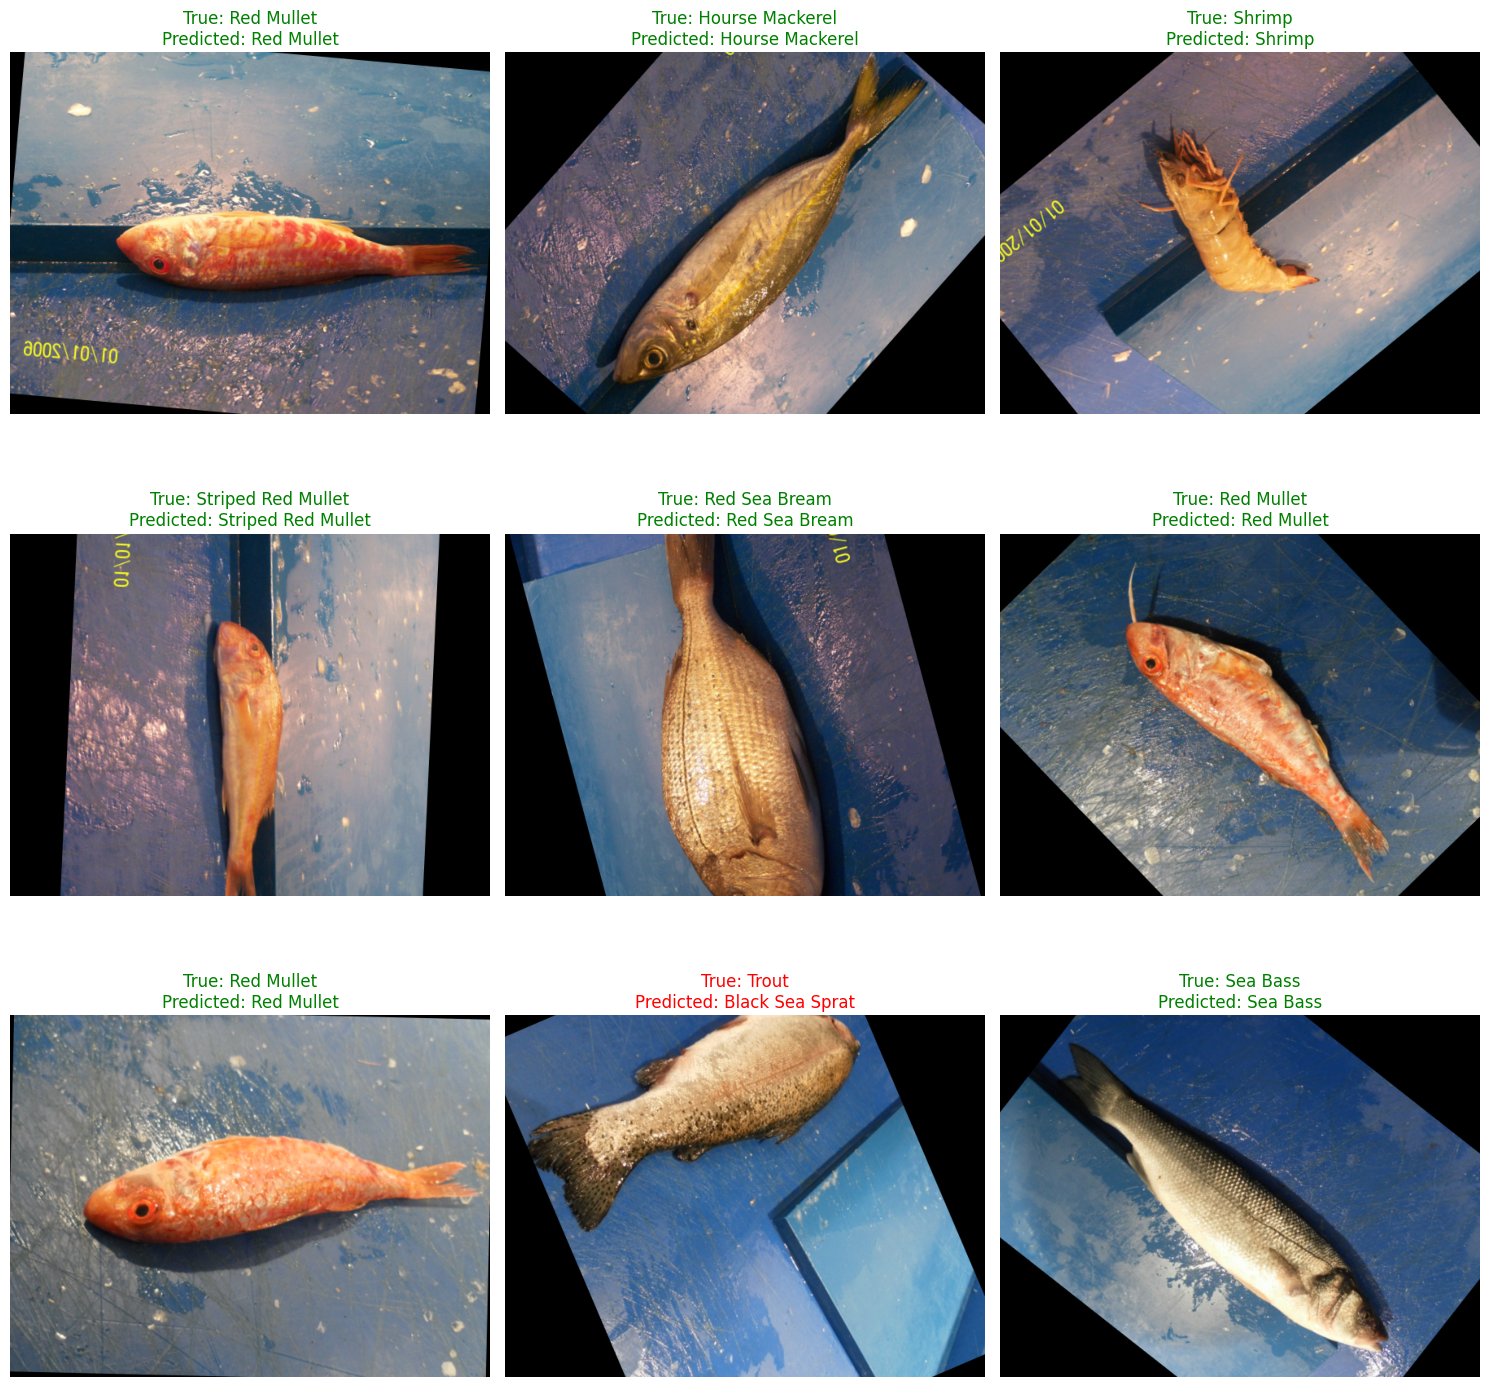

In [155]:
#Predictions of test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#Actual date of test
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#Random examples to see predictions and actual results
num_samples = 9 
random_indices = np.random.choice(len(true_labels), num_samples, replace=False)
test_images_paths = test_generator.filepaths 

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img_path = test_images_paths[idx]
    img = plt.imread(img_path)
    
    true_label = class_names[true_labels[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color='green' if true_label == predicted_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step


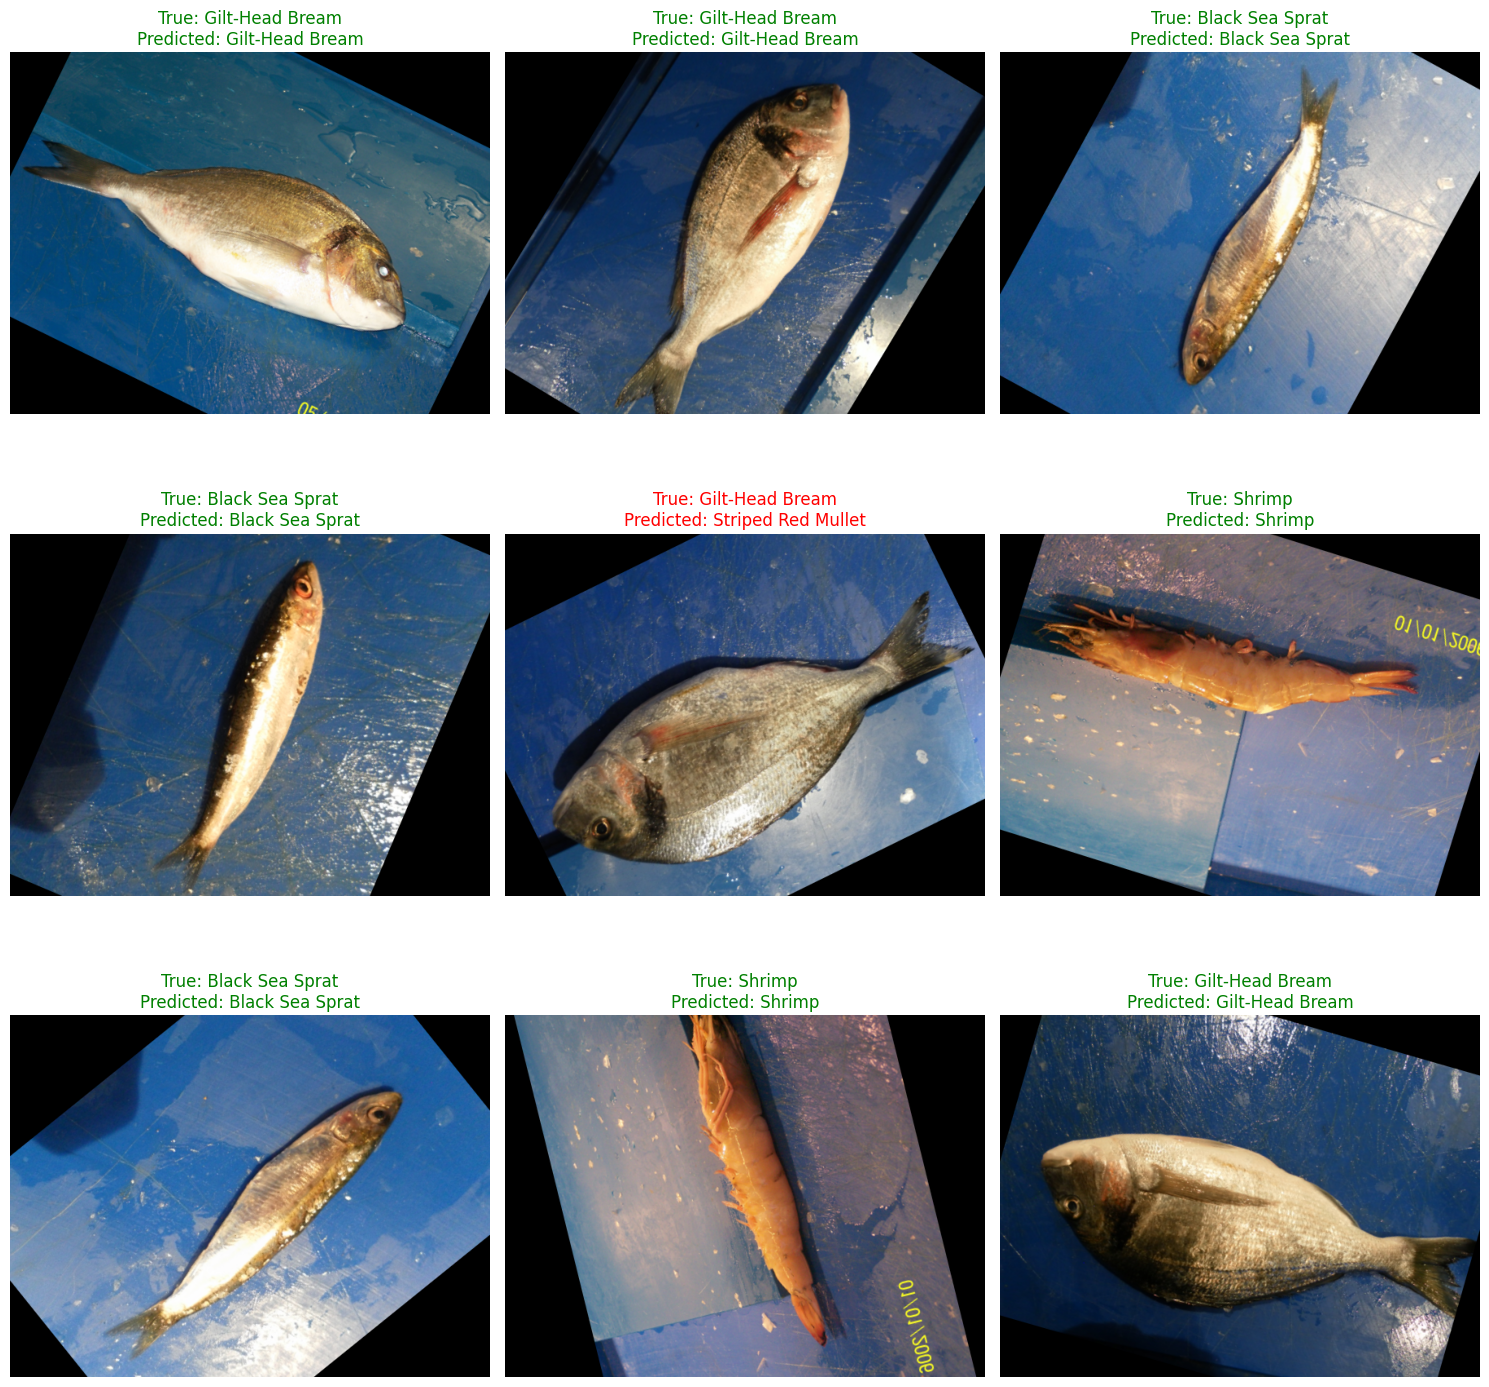

In [156]:
#Predictions of test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#Actual date of test
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

#Random examples to see predictions and actual results
num_samples = 9 
random_indices = np.random.choice(len(true_labels), num_samples, replace=False)
test_images_paths = test_generator.filepaths 

plt.figure(figsize=(15, 15))

for i, idx in enumerate(random_indices):
    img_path = test_images_paths[idx]
    img = plt.imread(img_path)
    
    true_label = class_names[true_labels[idx]]
    predicted_label = class_names[predicted_classes[idx]]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color='green' if true_label == predicted_label else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [157]:

# İlk batch'i almak için
for x_val, y_val in val_images:
    break  # İlk batch'i almak için döngüden çık
print(f'Validation batch shape: {x_val.shape}, Labels shape: {y_val.shape}')


Validation batch shape: (64, 224, 224, 3), Labels shape: (64, 9)
